Import necessary packages

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

Read in training and test data as well as a sample submission. Display data.

In [4]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
samp_sub = pd.read_csv('sample_submission.csv')
holdout.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Define functions to handle missing data depending on the feature.

In [5]:
#Replace na with mean
def processMissingMean(df,columns):
    "Handle various missing values from the data set"

    df[columns] = df[columns].fillna(df[columns].mean())
    return df

#Replace na with mode
def processMissingMode(df,columns):
    "Handle various missing values from the data set"

    df[columns] = df[columns].fillna(df[columns].mode().iloc[0])
    return df

#Replace na with mode
def processMissingMedian(df,columns):
    "Handle various missing values from the data set"

    df[columns] = df[columns].fillna(df[columns].median())
    return df

#Delete columns
def delete(df,columns):
    df = df.drop(columns, axis=1)
    return df

#Replace NAN in columns with NA
def processNA(df,columns):
    df[columns] = df[columns].fillna('NA')
    return df

#Create dummy columns (one hot encoding) from a single column
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

#Get a count of a particular attribute of certain feature
def countOf(df,columns,compare):
    numZero = 0
    for i in df[columns]:
        if i == compare:
            numZero += 1
    print(numZero, "instances of", compare)

In [6]:
#Concatenate training and test data in order to process it all at the same time. Leave out
#the Id and the SalePrice.
data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      holdout.loc[:,'MSSubClass':'SaleCondition']))

In [7]:
#Delete features that have mostly missing data
data.isnull().sum()
data = delete(data,['PoolQC','Fence','MiscFeature','Alley'])

In [8]:
#Process all missing data
data = processMissingMean(data,['LotFrontage','GarageYrBlt','GarageArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF'])
data = processMissingMode(data,['MasVnrType','Electrical','MSZoning','Utilities','Exterior1st','Exterior2nd','KitchenQual','Functional','SaleType'])
data = processMissingMedian(data,['MasVnrArea','BsmtFullBath','BsmtHalfBath','GarageCars'])
data = processNA(data,['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond'])

In [9]:
#Confirm all N/A entries have been filled. Get dummies for all data 
#as well as final number of features.
data.isnull().sum().sum()
data.shape
data = pd.get_dummies(data)
data.shape


(2919, 285)

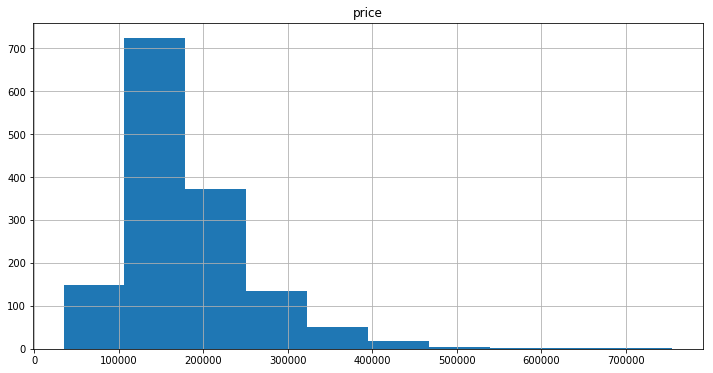

In [10]:
#Visualize sale prices.
plt.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"]})
prices.hist()
plt.show()

Since the sale price is skewed to the left, we can take the log of the sale price data to try to normalize it.

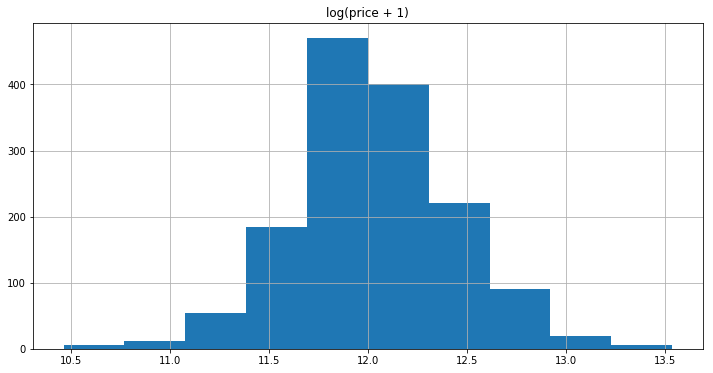

In [11]:
#Visualize log of sale prices.
plt.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()
plt.show()

In [12]:
#This looks better. Let's take the log of the actual sale prices. 
#Remember to do this on the test set.
train["SalePrice"] = np.log1p(train["SalePrice"])

In [13]:
#If some of the numerical values are also skewed, we take the log of them as well.
numeric_feats = data.dtypes[data.dtypes != "object"].index   
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]

skewed_feats = skewed_feats.index
data[skewed_feats] = np.log1p(data[skewed_feats])

In [15]:
#Pulling train/test sets out from concatenated set with same training size.
X_train = data[:train.shape[0]]
X_test = data[train.shape[0]:]
Y_train = train.SalePrice

In [16]:
#Extract training (x1) and cross validation set (x2) from original training set
x1, x2, y1, y2 = train_test_split(X_train, Y_train, train_size=0.75, random_state=42)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
#Since the number of features in this dataset was manageable, we did not need to use this function
def select_features(df,exclude,yVal):
    df = df.select_dtypes(include=['number'])
    df = df.dropna(axis=1, how='any')
    all_X = df.loc[:, df.columns != exclude]
    all_X = all_X.loc[:, all_X.columns != yVal]
    all_y = df[yVal]
    rfc = RandomForestClassifier(random_state=1)
    selector = RFECV(rfc,cv=10)
    selector.fit(all_X,all_y)
    optimized_columns = all_X.columns[selector.support_]
    print(optimized_columns)
    return optimized_columns

In [34]:
#Determine optimimal columns from training set and concatenate with SalePrice.
#optCols = select_features(train,'Id','SalePrice')
#trainOpt = pd.concat([train.loc[:,optCols], train.loc[:,'SalePrice']],axis = 1)
#all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
#                      test.loc[:,'MSSubClass':'SaleCondition']))

In [21]:
#Create a dictionary of models that are each stored as dictionaries. 
#Within each model are parameters that will then be tuned with a GridSeachCV.
#Some of the parameter lists for random forest and gradient boosting have been paired down
# because of long runtimes. However, these parameters were optimized.
def select_model(all_X,all_y):
    dictList = []

    RD = {"name": "Ridge",
          "estimator": Ridge(),
          "hyperparameters": 
         {
             "alpha" : [0.1, 1, 5, 10],
             "random_state" : [1,2,10]
         }
    }
    
    LS = {"name": "Lasso",
          "estimator": Lasso(),
          "hyperparameters": 
         {
             "alpha" : [0.001, 0.0005,0.0004],
             "random_state" : [23]
             
         }
    }
    
    EN = {"name": "ElasticNet",
          "estimator": ElasticNet(),
          "hyperparameters": 
         {
             "alpha" : [0.0001,0.0003, 0.0005],
             "l1_ratio" : [.1, .9, .99],
             "max_iter" : [5000],
             "random_state" : [3]
         }
    }
    
    RF = {"name": "RandomForest",
          "estimator": RandomForestRegressor(),
          "hyperparameters": 
         {
             "n_estimators" : [3000],
             "random_state" : [11]
         }
    }
    
    GRB = {"name": "Gradient Boosting",
          "estimator": GradientBoostingRegressor(),
          "hyperparameters": 
         {
             "n_estimators" : [3000],
             "learning_rate" : [0.05],
             "max_depth" : [3],
             "max_features" : ['sqrt'],
             "min_samples_leaf" : [15],
             'min_samples_split' : [10],
             'loss' : ['huber'],
             'random_state' : [5]
         }
    }
    
    XGB = {"name": "XG Boosting",
          "estimator": xgb.XGBRegressor(),
          "hyperparameters": 
         {
             "n_estimators" : [100,360,1000],
             "max_depth" : [2,6,10],
             'learning_rate' : [0.01,0.1,1],
             'seed' : [5,7,10]
         }
    }
    
    dictList = [RD,LS,EN,RF,GRB,XGB]
    
    for item in dictList:
        print(item["name"])
        grid = GridSearchCV(item["estimator"],param_grid=item["hyperparameters"],cv=10)
        grid.fit(all_X, all_y)
        item["best_params"] = grid.best_params_
        item["best_score"] = grid.best_score_
        item["best_estimator"] = grid.best_estimator_
        print(grid.best_params_)
        print(grid.best_score_)
    
    return dictList    

In [22]:
#Determine best parameters of each model and view scores of the model
newDictList = select_model(X_train,Y_train)

Ridge
{'alpha': 5, 'random_state': 1}
0.897989658735
Lasso
{'alpha': 0.0004, 'random_state': 23}
0.903210150745
ElasticNet
{'alpha': 0.0003, 'l1_ratio': 0.9, 'max_iter': 5000, 'random_state': 3}
0.90363208421
RandomForest
{'n_estimators': 3000, 'random_state': 11}
0.875649416789
Gradient Boosting
{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 3000, 'random_state': 5}
0.906108734445
XG Boosting
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000, 'seed': 5}
0.905740092737


In [23]:
#We will not include the random forest model in our ensemble model because of its poor score
del newDictList[3]

In [30]:
len(newDictList)

5

In [24]:
#Create ensemble model (average of each model) and make predictions
def create_ensemble_pred(df,modelList):
    Y_pred_list = []
    for model in modelList:
        Y_pred_list.append(model['best_estimator'].predict(df))
    pred = sum(Y_pred_list) / len(Y_pred_list)
    return pred

In [25]:
pred = create_ensemble_pred(X_test,newDictList)
Y_pred = np.exp(pred)
Y_pred

array([ 119822.50754544,  156681.9945336 ,  184892.52787982, ...,
        165767.67959759,  117608.92389768,  222844.62165723])

In [26]:
#Save submissions file
def save_submission_file(df,Y_pred):
    submission = pd.DataFrame({
        "Id": df["Id"],
        "SalePrice": Y_pred
    })
    submission.to_csv('submission.csv', index=False)

In [27]:
save_submission_file(holdout,Y_pred)

In [28]:
#Check length of predictions
len(Y_pred)

1459